---
---

<h1 align='center'> Anamoly Detection </h1>
<h2 align='center'> Log Parsing and PreProcessing</h2> 

**DATASET: HDFS (Hadoop Distributed File System)**
Links:
- (2k)Log - https://raw.githubusercontent.com/logpai/loghub/master/HDFS/HDFS_2k.log
- Entire Data - https://zenodo.org/record/3227177/files/HDFS_1.tar.gz

---
---

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.utils import shuffle
from collections import OrderedDict
import transformers
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.datasets import mnist
import tensorflow as tf
from tensorflow.keras import preprocessing
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.utils import np_utils
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score
from mlxtend.plotting import plot_confusion_matrix
from keras import datasets, layers, models, losses
import warnings
warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'transformers'

### Loading HDFS

In [2]:
def loadhdfs(log_file, label_file, save_csv= True):
    struct_logg = pd.read_csv(struct_log, engine='c',
                na_filter=False, memory_map=True)
    data_dict = OrderedDict()
    label_data = pd.read_csv(label_file, engine='c', na_filter=False, memory_map=True)
    label_data = label_data.set_index('BlockId')
    label_dict = label_data['Label'].to_dict()
    struct_logg['label'] = struct_logg['Content'].apply(lambda x: 1 if label_dict[ re.findall(r'(blk_-?\d+)', x)[0]] == 'Anomaly' else 0)
    if save_csv:
        struct_logg.to_csv('data_instances.csv', index=False)
    
    return struct_logg

In [4]:
struct_log = "HDFS_2k.log_structured.csv" # The structured log file
label_file = 'anomaly_label.csv' # The anomaly label file

log_df= loadhdfs(struct_log,label_file)
log_df

,LineId,Date,Time,Pid,Level,Component,Content,EventId,EventTemplate,ParameterList,label
0,1,81109,203615,148,INFO,dfs.DataNode$PacketResponder,PacketResponder 1 for block blk_38865049064139...,dc2c74b7,PacketResponder <*> for block <*> terminating,"['1', 'blk_38865049064139660']",0
1,2,81109,203807,222,INFO,dfs.DataNode$PacketResponder,PacketResponder 0 for block blk_-6952295868487...,dc2c74b7,PacketResponder <*> for block <*> terminating,"['0', 'blk_-6952295868487656571']",0
2,3,81109,204005,35,INFO,dfs.FSNamesystem,BLOCK* NameSystem.addStoredBlock: blockMap upd...,5d5de21c,BLOCK* NameSystem.addStoredBlock: blockMap upd...,"['10.251.73.220:50010', 'blk_71283702376877284...",0
3,4,81109,204015,308,INFO,dfs.DataNode$PacketResponder,PacketResponder 2 for block blk_82291938032499...,dc2c74b7,PacketResponder <*> for block <*> terminating,"['2', 'blk_8229193803249955061']",0
4,5,81109,204106,329,INFO,dfs.DataNode$PacketResponder,PacketResponder 2 for block blk_-6670958622368...,dc2c74b7,PacketResponder <*> for block <*> terminating,"['2', 'blk_-6670958622368987959']",0
...,...,...,...,...,...,...,...,...,...,...,...
1995,1996,81111,101621,24902,INFO,dfs.DataNode$DataXceiver,Receiving block blk_4198733391373026104 src: /...,09a53393,Receiving block <*> src: <*> dest: <*>,"['blk_4198733391373026104', '/10.251.106.10:46...",0
1996,1997,81111,101735,26595,INFO,dfs.DataNode$PacketResponder,Received block blk_-5815145248455404269 of siz...,e3df2680,Received block <*> of size <*> from <*>,"['blk_-5815145248455404269', '67108864', '/10....",0
1997,1998,81111,101804,26494,INFO,dfs.DataNode$DataXceiver,Receiving block blk_-295306975763175640 src: /...,09a53393,Receiving block <*> src: <*> dest: <*>,"['blk_-295306975763175640', '/10.250.9.207:532...",0
1998,1999,81111,101954,26414,INFO,dfs.DataNode$PacketResponder,PacketResponder 0 for block blk_52257196770490...,dc2c74b7,PacketResponder <*> for block <*> terminating,"['0', 'blk_5225719677049010638']",0


### preprocessing

In [5]:
clean = []
filename = "data_instances.csv" 
y_data =[]
x_data =[]
with open(filename) as file:
    lines = file.readlines()
    lines = [line.rstrip() for line in lines]
for i in range(len(lines)):    
    lines[i] = lines[i].replace(',',' ').replace("-", "_").replace("_", "")
    temp = re.sub(r'\W+', ' ',lines[i])
    y_data.append(temp[-1:])
    x_data.append(temp[:-1])

In [8]:
data = pd.DataFrame(list(zip(x_data[1:],y_data[1:])),
               columns =['X_data', 'Y_data'])
data

,X_data,Y_data
0,1 81109 203615 148 INFO dfs DataNode PacketRes...,0
1,2 81109 203807 222 INFO dfs DataNode PacketRes...,0
2,3 81109 204005 35 INFO dfs FSNamesystem BLOCK ...,0
3,4 81109 204015 308 INFO dfs DataNode PacketRes...,0
4,5 81109 204106 329 INFO dfs DataNode PacketRes...,0
...,...,...
1995,1996 81111 101621 24902 INFO dfs DataNode Data...,0
1996,1997 81111 101735 26595 INFO dfs DataNode Pack...,0
1997,1998 81111 101804 26494 INFO dfs DataNode Data...,0
1998,1999 81111 101954 26414 INFO dfs DataNode Pack...,0


In [7]:
data.to_csv('cleaned_2k.data.csv', index=False)

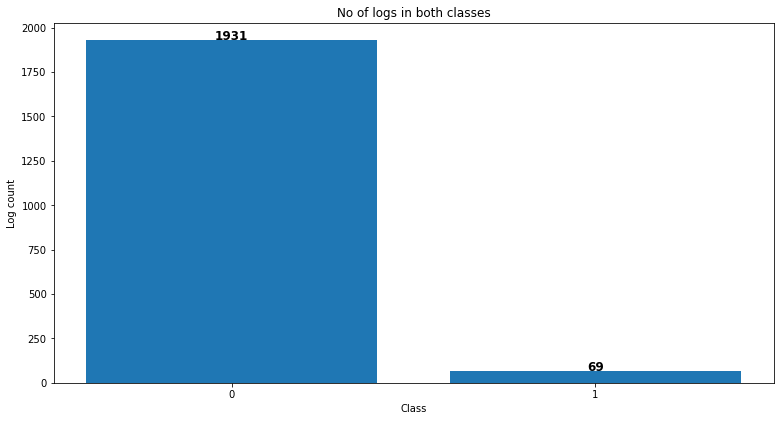

In [22]:
fig = plt.figure(figsize =(10,5))
ax = fig.add_axes([0,0,1,1])
def add_value_label(x_list,y_list):
    for i in range(1, len(x_list)+1):
        plt.text(i-1,y_list[i-1],y_list[i-1],ha="center",fontsize=12,fontweight="bold")
y_count = np.bincount(data['Y_data'])
labels = ['0', '1']
ax.bar(labels,y_count)
add_value_label(labels,y_count)
ax.set_xlabel('Class')
ax.set_ylabel('Log count')
ax.set_title('No of logs in both classes')
plt.show()

In [23]:
x_train, x_test, y_train, y_test = train_test_split(data['X_data'], data['Y_data'], test_size=0.2, random_state=12)

In [25]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1600,)
(1600,)
(400,)
(400,)


In [38]:
def tokenize_bert(corpus, maxlen=None):
    tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True) 
    maxlen = np.max([len(txt.split(" ")) for txt in corpus]) if maxlen is None else maxlen
    if maxlen < 20:
        raise Exception("maxlen cannot be less than 20")
    else:
        print("maxlen:", maxlen)

    ## add special tokens: [CLS] my name is mau ##ro [SEP]
    maxqnans = np.int32((maxlen-20)/2)
    corpus_tokenized = ["[CLS] "+
                        " ".join(tokenizer.tokenize(re.sub(r'[^\w\s]+|\n', '', str(txt).lower().strip()))[:maxqnans])+
                        " [SEP] " for txt in corpus]
   
    ## generate masks: [1, 1, 1, 1, 1, 1, 1, | (padding) 0, 0, 0, 0, 0, ...]
    masks = [[1]*len(txt.split(" ")) + [0]*(maxlen - len(txt.split(" "))) for txt in corpus_tokenized]
    
    ## padding
    #corpus_tokenized = kprocessing.sequence.pad_sequences(corpus_tokenized, maxlen=maxlen, dtype=object, value='[PAD]')
    txt2seq = [txt + " [PAD]"*(maxlen-len(txt.split(" "))) if len(txt.split(" ")) != maxlen else txt for txt in corpus_tokenized]
    
    ## generate idx: [101, 22, 35, 44, 50, 60, 102, 0, 0, 0, 0, 0, 0, ...]
    idx = [tokenizer.encode(seq.split(" ")) for seq in txt2seq]
    
    ## generate segments: [0, 0, 0, 0, 0, 0, 1 [SEP], 0, 0, 0, 0, 2 [SEP], 0, ...]
    segments = [] 
    for seq in txt2seq:
        temp, i = [], 0
        for token in seq.split(" "):
            temp.append(i)
            if token == "[SEP]":
                i += 1
        segments.append(temp)
    
    ## check
    genLength = set([len(seq.split(" ")) for seq in txt2seq])
    if len(genLength) != 1: 
        print(genLength)
        raise Exception("--- texts are not of same size ---")

    X = [np.asarray(idx, dtype='int32'), np.asarray(masks, dtype='int32'), np.asarray(segments, dtype='int32')]
    print("created tensor idx-masks-segments:", str(len(X))+"x "+str(X[0].shape))
    return X

In [39]:
x_bert_train = tokenize_bert(corpus=x_train, maxlen=50)
x_bert_test = tokenize_bert(corpus=x_test, maxlen=50)

maxlen: 50
created tensor idx-masks-segments: 3x (1600, 52)
maxlen: 50
created tensor idx-masks-segments: 3x (400, 52)


In [41]:
x_bert_train[0] = x_bert_train[0][:,:50]
x_bert_test[0] = x_bert_test[0][:,:50]

In [47]:
idx = layers.Input((50), dtype="int32", name="input_idx")
masks = layers.Input((50), dtype="int32", name="input_masks")
## pre-trained bert with config
config = transformers.DistilBertConfig(dropout=0.2, attention_dropout=0.2)
config.output_hidden_states = False
nlp = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased', config=config)
bert_out = nlp(idx, attention_mask=masks)[0]
## fine-tuning
x = layers.GlobalAveragePooling1D()(bert_out)
x = layers.Dense(64, activation="relu")(x)
y_out = layers.Dense(len(np.unique(y_train)), activation='softmax')(x)
## compile
model = models.Model([idx, masks], y_out)
for layer in model.layers[:3]:
    layer.trainable = False
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Downloading:   0%|          | 0.00/347M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_layer_norm', 'activation_13', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_idx (InputLayer)         [(None, 50)]         0           []                               
                                                                                                  
 input_masks (InputLayer)       [(None, 50)]         0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  66362880   ['input_idx[0][0]',              
 BertModel)                     ast_hidden_state=(N               'input_masks[0][0]']            
                                one, 50, 768),                                                    
                                 hidden_states=None                                           

In [48]:
dic_y_mapping = {n:label for n,label in enumerate(np.unique(y_train))}
inverse_dic = {v:k for k,v in dic_y_mapping.items()}
y_train = np.array( [inverse_dic[y] for y in y_train])
    
history = model.fit(x=x_bert_train[:2], y=y_train, batch_size=64, epochs=10, validation_split=0.2)

Epoch 1/10
20/20 [==============================] - 40s 2s/step - loss: 0.2241 - accuracy: 0.9211 - val_loss: 0.1657 - val_accuracy: 0.9656
Epoch 2/10
20/20 [==============================] - 38s 2s/step - loss: 0.1540 - accuracy: 0.9664 - val_loss: 0.1497 - val_accuracy: 0.9656
Epoch 3/10
20/20 [==============================] - 37s 2s/step - loss: 0.1474 - accuracy: 0.9664 - val_loss: 0.1498 - val_accuracy: 0.9656
Epoch 4/10
20/20 [==============================] - 43s 2s/step - loss: 0.1471 - accuracy: 0.9664 - val_loss: 0.1499 - val_accuracy: 0.9656
Epoch 5/10
20/20 [==============================] - 38s 2s/step - loss: 0.1463 - accuracy: 0.9664 - val_loss: 0.1502 - val_accuracy: 0.9656
Epoch 6/10
20/20 [==============================] - 38s 2s/step - loss: 0.1464 - accuracy: 0.9664 - val_loss: 0.1504 - val_accuracy: 0.9656
Epoch 7/10
20/20 [==============================] - 41s 2s/step - loss: 0.1450 - accuracy: 0.9664 - val_loss: 0.1514 - val_accuracy: 0.9656
Epoch 8/10
20/20 [==

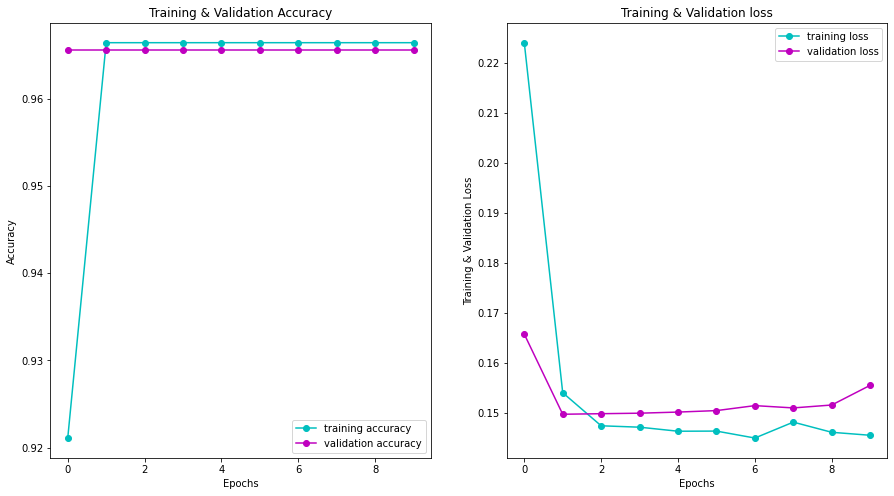

In [50]:
def plot_accuracy_and_loss_of_train_and_validation_dataset(history):
    train_acc=history.history['accuracy']
    train_loss=history.history['loss']
    val_acc=history.history['val_accuracy']
    val_loss=history.history['val_loss']
    epoch=[i for i in range(len(train_acc))]
    fig , ax=plt.subplots(1,2)
    fig.set_size_inches(15,8)
    ax[0].plot(epoch,train_acc,'co-',label='training accuracy')
    ax[0].plot(epoch,val_acc,'mo-',label='validation accuracy')
    ax[0].set_title('Training & Validation Accuracy')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")
    ax[1].plot(epoch,train_loss,'c-o',label='training loss')
    ax[1].plot(epoch,val_loss,'m-o',label='validation loss')
    ax[1].set_title('Training & Validation loss')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Training & Validation Loss")

# incase of early stop
plot_accuracy_and_loss_of_train_and_validation_dataset(history)

In [55]:
#model = keras.models.load_model(model_file) # rollback to best model
loss,accuracy = model.evaluate(x_bert_train[:2],y_train)
print("The accuracy of train text is : ",accuracy)

50/50 [==============================] - 33s 645ms/step - loss: 0.1498 - accuracy: 0.9663
The accuracy of train text is :  0.9662500023841858


In [65]:
print("Predicting Test data using the above Trained model...")
predicted_prob = model.predict(x_bert_test[:2])
predicted = [dic_y_mapping[np.argmax(pred)] for pred in predicted_prob]

Predicting Test data using the above Trained model...


In [68]:
class_names = ['Normal','Anomaly']

In [71]:
print(classification_report(y_test, predicted,target_names=class_names))

              precision    recall  f1-score   support

      Normal       0.96      1.00      0.98       385
     Anomaly       0.00      0.00      0.00        15

    accuracy                           0.96       400
   macro avg       0.48      0.50      0.49       400
weighted avg       0.93      0.96      0.94       400



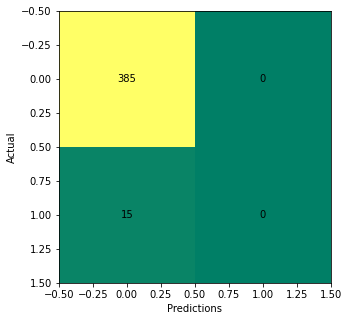

In [80]:
CM = confusion_matrix(y_test, predicted)
# Plot confusion matrix
plt.figure(figsize = (5,5))
plt.imshow(CM,interpolation='nearest',cmap='summer')
for (i, j), z in np.ndenumerate(CM):
    plt.text(j, i, z, ha='center', va='center')
plt.xlabel("Predictions")
plt.ylabel("Actual")
plt.grid(False)
plt.show()

### Solving Data Imbalance 

In [113]:
# import library
from imblearn.over_sampling import SMOTE
from collections import Counter

smote = SMOTE()

# fit predictor and target variable
x_smote, y_smote = smote.fit_resample(x_bert_train[0], y_train)

print('Original dataset shape', x_bert_train[0].shape)
print('Resample dataset shape', x_smote.shape)

Original dataset shape (1600, 50)
Resample dataset shape (3092, 50)


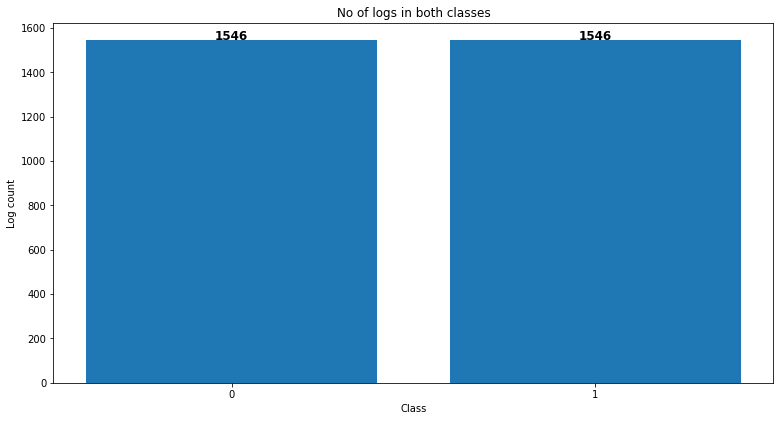

In [115]:
fig = plt.figure(figsize =(10,5))
ax = fig.add_axes([0,0,1,1])
def add_value_label(x_list,y_list):
    for i in range(1, len(x_list)+1):
        plt.text(i-1,y_list[i-1],y_list[i-1],ha="center",fontsize=12,fontweight="bold")
y_count = np.bincount(y_smote)
labels = ['0', '1']
ax.bar(labels,y_count)
add_value_label(labels,y_count)
ax.set_xlabel('Class')
ax.set_ylabel('Log count')
ax.set_title('No of logs in both classes')
plt.show()